<h1><center>API EVALUATION</center></h1>

# 1. Introduction

## Goal
The goal is to test the accuracy of various Face detection web APIs which offer, among other features, emotion recognition.

## Method/Introduction
The web APIs were chosen considering the ones which offered a free plan or free trial.

The programming language used is `Python`. The solutions which offered SDKs which leveraged different programming languages were not considered in this study, as well as the others which did not provide any interface at all to communicate with.

A script is used to send in parallel the whole image set to the various APIs. The raw `json` result and the computed emotions are then stored locally respectively in separate `.json` and `.csv` files for further processing. 
Single snippets have then be created to test both single pictures and the whole image set in order to investigate and compare their accuracy.

## APIs used
The APIs that have been tested are:

**[Amazon Rekognition](https://aws.amazon.com/rekognition/)**<br/>
The detected emotions are `HAPPY | SAD | ANGRY | CONFUSED | DISGUSTED | SURPRISED | CALM | UNKNOWN` and they are associated with a confidence level `[0, 100]`. Only a subset of the previously metioned emotions are returned for each request.

Following are some useful links:
* [api](http://docs.aws.amazon.com/rekognition/latest/dg/faces.html)
* [code sample](http://docs.aws.amazon.com/rekognition/latest/dg/get-started-exercise.html)
* [boto python aws sdk](https://github.com/boto/boto3)
* [emotion param](http://docs.aws.amazon.com/rekognition/latest/dg/API_Emotion.html)

**[Google Cloud Vision](https://cloud.google.com/vision/)**<br/>
The detected emotions are `joy, sorrow, anger, surprise` and they are associated with a confidence level `UNKNOWN, VERY_UNLIKELY, UNLIKELY, POSSIBLE, LIKELY, VERY_LIKELY`.

**[Microsoft Azure Emotion](https://azure.microsoft.com/en-us/services/cognitive-services/emotion/)**<br/>
The detected emotions are `neutral, fear, contempt, disgust, happiness, sadness, surprise` and they are associated with a confidence level `[0,1]`.

**[Face++](https://www.faceplusplus.com)**<br/>
The detected emotions are `fear, anger, neutral, disgust, surprise, happiness` and they are associated with a confidence level `[0, 100]`.

**[Kairos](http://kairos.com/)**<br/>
The detected emotions are `anger, disgust, fear, joy, sadness, surprise` and they are associated with a confidence level `[0, 100]`.

As it appears, not all the APIs are consistent in the emotions detected. To ensure a comparison between the various APIs the output has been uniformed to the following set of emotions: `anger, disgust, fear, joy, neutral, sadness, surprise` associated with a confidence level `[0, 100]`

It is also important to note that the emotions are only a subset of the information retrived from the API. Other features such as facial landmarks, age estimation etc.. may be available.

## Dataset used
The dataset used is the [Cohn-Kanade CK+ dataset](http://www.consortium.ri.cmu.edu/ckagree/) which comprises 6xx pictures, labeled with both _Action Units_ and emotions.

The emotions provided are as follow:
```json
{ 0:'neutral', 1:'anger', 2:'contempt', 3:'disgust', 4:'fear', 5:'happy', 6:'sadness', 7:'surprise' }
```

Since _contempt_ and _disgust_ convey the same facial expression and are difficult to distinguish even by a person, they will be considered as a unique emotion.
So the labeled emotions will be
```json
['neutral', 'anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
```

## Results
....

# 2. The coding approach

## Selecting the images
While the CK+ dataset is composed of images sequence, only the last one, namely the one expressing the highest intensity for the respective emotion was chosen to be sent to each API. This decision was made because the labels are referred to the last image of the sequence and thus it's the most representative.

## Sending the images to the APIs
The process of sending the images to each API listed above is taken care by the `api_query.py` script which leverages `multiprocessing` and `aiohttp` for sending parallel requests and optimize the time needed to complete the requests.

Each API handler has been specifically tuned to the limits imposed by the free account usage of each.

To avoid cluttering the space of this notebook with commented code, the scripts are available below, as attachments:
* [/scripts/api_query.py](/edit/scripts/apis/api_query.py) - Handles the main API communication
* [/scripts/api_structure.py](/edit/scripts/apis/api_structure.py) - Keeps the information and the response structure of each API
* [/scripts/api_keys.py](/edit/scripts/apis/api_keys.py) - Stores the private keys of each API

All the images to send to the APIs should be stored in the `/scripts/img/` folder.

The response of each API is standardized and stores the confidence of the following set of emotions `['neutral', 'anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']`. The values are stored in the `o_csv/out.csv` file and each response from the api is stored in multiple `o_json/*.json` files.

# 3. Analyzing the results

## Loading the dataset

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# setting font size
sns.set(font_scale=1.4)
# setting a default color palette for the charts
sns.set_palette('Paired', n_colors=10)
# set grid in all charts
plt.grid(True)

%matplotlib inline

In [3]:
# let's load the file with the emotions computed by the various APIs
df = pd.read_csv('../scripts/apis/o_csv/out.csv', sep=',', index_col='id')
df.head()

,img_name,source,anger,disgust,fear,joy,neutral,sadness,surprise
id,,,,,,,,,
S087_004_00000012_amazon,S087_004_00000012,amazon,32.352417,3.082138,0.0,0.000000,0.0,3.132832,0.0
S138_008_00000009_amazon,S138_008_00000009,amazon,0.000000,0.000000,0.0,67.143562,0.0,42.504555,0.0
S050_006_00000023_amazon,S050_006_00000023,amazon,0.000000,0.000000,0.0,99.953857,0.0,0.000000,0.0
S060_002_00000026_amazon,S060_002_00000026,amazon,0.000000,0.000000,0.0,98.946846,0.0,0.000000,0.0
S151_002_00000029_amazon,S151_002_00000029,amazon,0.000000,0.000000,0.0,96.703247,0.0,0.000000,0.0


In [4]:
# let's load the file with the true emotions
label_df = pd.read_csv('../data/labeled_light.csv', sep=',', index_col='img_name', usecols=['img_name', 'emotion'])
label_df.head()

,emotion
img_name,
S091_001_00000001,0
S503_001_00000001,0
S029_001_00000001,0
S138_001_00000001,0
S064_001_00000001,0


The labels of the `CK+` dataset are numbers associated to an emotion. Since `contempt` and `disgust` are very similar in meaning and facial expression, they will be considered both as `disgust`.

In [81]:
# original
# { 0:'neutral', 1:'anger', 2:'contempt', 3:'disgust', 4:'fear', 5:'happy', 6:'sadness', 7:'surprise' }

# converted
emotion_conversion = {
    0: 'neutral',
    1: 'anger',
    2: 'disgust',
    3: 'disgust',
    4: 'fear',
    5: 'joy',
    6: 'sadness',
    7: 'surprise'
}
label_df.emotion = label_df.emotion.apply(lambda x: emotion_conversion[x])
label_df.head()

,emotion
img_name,
S091_001_00000001,neutral
S503_001_00000001,neutral
S029_001_00000001,neutral
S138_001_00000001,neutral
S064_001_00000001,neutral


## Analyzing the output of single images

In [7]:
# let's pick 3 images at random and check the results
nr_rand_img = 3

unique_img = df.img_name.unique()
rand_img = unique_img[np.random.randint(len(unique_img), size=nr_rand_img)]

rand_df = df.loc[df.img_name.isin(rand_img)]
rand_df.head()

,img_name,source,anger,disgust,fear,joy,neutral,sadness,surprise
id,,,,,,,,,
S138_008_00000009_amazon,S138_008_00000009,amazon,0.000000e+00,0.000000,0.000000e+00,67.143562,0.000000,4.250455e+01,0.000000
S050_006_00000023_amazon,S050_006_00000023,amazon,0.000000e+00,0.000000,0.000000e+00,99.953857,0.000000,0.000000e+00,0.000000
S151_002_00000029_amazon,S151_002_00000029,amazon,0.000000e+00,0.000000,0.000000e+00,96.703247,0.000000,0.000000e+00,0.000000
S050_006_00000023_azure,S050_006_00000023,azure,8.963460e-07,0.000056,1.224612e-08,99.999607,0.000317,1.716531e-07,0.000015
S138_008_00000009_azure,S138_008_00000009,azure,9.356358e-03,0.028575,1.488917e-04,76.976970,22.294352,2.502851e-02,0.005060


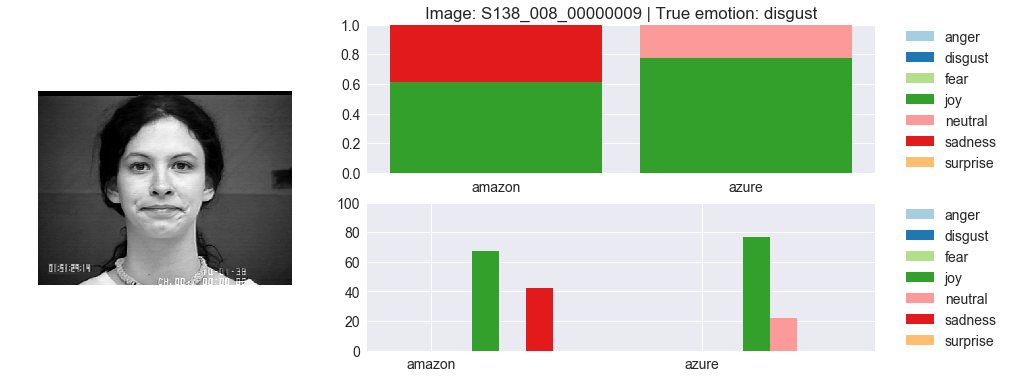

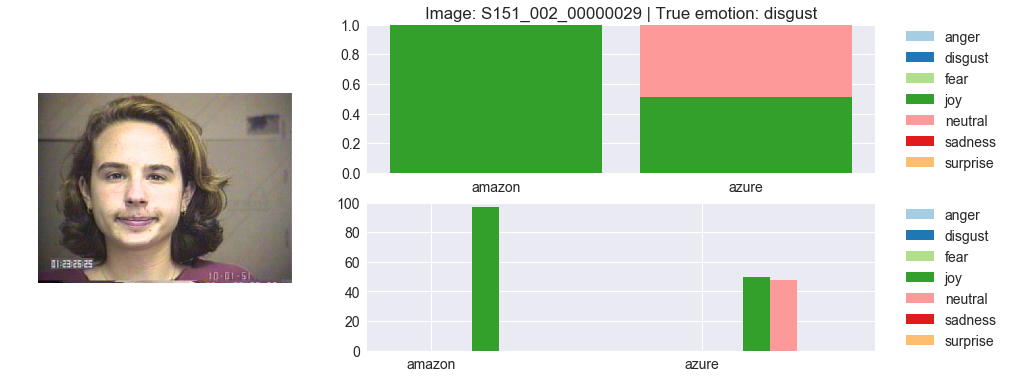

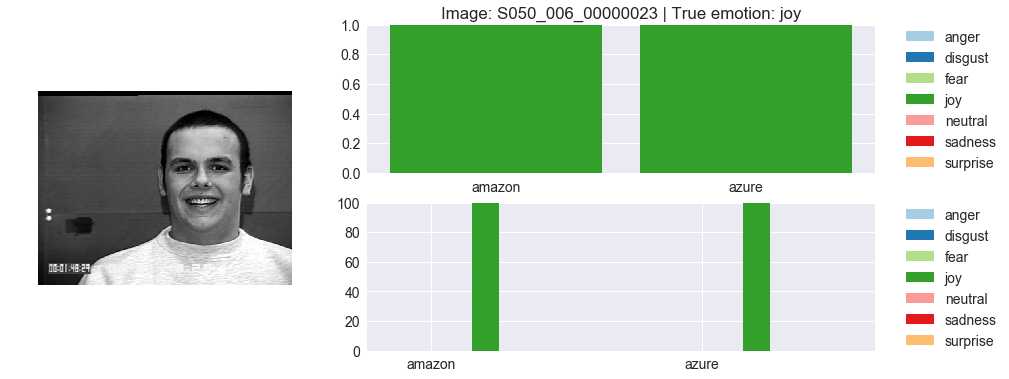

In [112]:
# function to normalize row in order to make each value a percentage of the row total
def normalize(x):
    return x/x.sum()

# normalize each row so that it sums up to 1
rand_df_norm = rand_df.iloc[:, 2:].apply(normalize, axis=1)

# create the charts for each image
for i in range(nr_rand_img):
    
    fig = plt.figure(figsize=(15, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])
    ax1 = plt.subplot(gs[:, 0])
    ax2 = plt.subplot(gs[:-1, 1])
    ax3 = plt.subplot(gs[-1, 1])
    
    ax2.grid(True, axis='y')
    ax3.grid(True, axis='y')
    ax2.set_axisbelow(True)
    ax3.set_axisbelow(True)
    
    current_img = rand_img[i]
    current_img_norm_df = rand_df_norm.loc[rand_df.img_name == current_img]
    current_img_df = rand_df.loc[rand_df.img_name == current_img]
    
    # IMAGE
    # read image from disk
    img = mpimg.imread('../scripts/apis/img/{}.png'.format(current_img))
    img = ax1.imshow(img, cmap='gray')
    ax1.axis('off')
    
    # STACKED BARPLOT WITH NORMALIZED VALUES
    # initialize variable that will be needed to build the stacked barplot
    sum = [0]*current_img_norm_df.shape[0]
    x = []
    # for each emotion, create the bar which will then be stacked
    for j, e in enumerate(current_img_norm_df.columns):
        emotion = ax2.bar(current_img_norm_df.index, current_img_norm_df.iloc[:, j], 0.85, bottom=sum)
        x.append(emotion)
        sum += current_img_norm_df.iloc[:, j]
    ax2.set_xticklabels(current_img_df.source.unique())
    # show labeled emotion in chart title
    ax2.set_title('Image: {} | True emotion: {}'.format(current_img, label_df.loc[current_img].emotion))
    # add legend
    ax2.legend(x, current_img_norm_df.columns, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    # BARPLOT WITH REAL VALUES
    y = []
    barWidth = 0.1
    n = current_img_df.source.shape[0]
    for i, c in enumerate(current_img_df.columns[2:]):
        y.append(ax3.bar(np.arange(n) + i*barWidth, current_img_df[c], barWidth))
    rect = [y[i][0] for i in np.arange(len(y))]
    labels = [name for name in current_img_df.columns[2:]]
    ax3.legend(rect, labels, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    ax3.set_ylim(0, 100)
    ax3.xaxis.set_ticks([r + barWidth for r in np.arange(n)])
    ax3.set_xticklabels(current_img_df.source.unique())

## Comparing the results of the APIs with true labeled emotions
In this sections the real labeled values of the emotions will be compared to the emotion with the highest confidence level returned by each API.

In [147]:
# BUILD THE DATAFRAME
# function to find the maximum confidence level value and it's associated emotion
def find_index(x):
    m = x.max()
    i = x.tolist().index(m)
    return x.index[i], m

# initialize dataframe
compare_df = pd.DataFrame(columns=['img_name', 'source'], index=df.index)
compare_df.img_name = df.img_name
compare_df.source = df.source

# add column relative to the emotion "computed" by the API and its confidence level
compare_df['computed'], compare_df['confidence'] = zip(*df.iloc[:, 3:].apply(find_index, axis=1))

# add the column relative to the real emotion, as found on the labeled dataset
compare_df = compare_df.join(label_df, on='img_name')
compare_df.rename(columns={'emotion':'real'}, inplace=True)

# add the column that tracks whether computed and emotion are equal
compare_df['correct'] = compare_df.computed == compare_df.real
compare_df

,img_name,source,computed,confidence,real,correct
id,,,,,,
S087_004_00000012_amazon,S087_004_00000012,amazon,sadness,3.132832,disgust,False
S138_008_00000009_amazon,S138_008_00000009,amazon,joy,67.143562,disgust,False
S050_006_00000023_amazon,S050_006_00000023,amazon,joy,99.953857,joy,True
S060_002_00000026_amazon,S060_002_00000026,amazon,joy,98.946846,joy,True
S151_002_00000029_amazon,S151_002_00000029,amazon,joy,96.703247,disgust,False
S999_003_00000055_amazon,S999_003_00000055,amazon,joy,12.621100,fear,False
S077_001_00000028_amazon,S077_001_00000028,amazon,surprise,91.978363,surprise,True
S050_006_00000023_azure,S050_006_00000023,azure,joy,99.999607,joy,True
S060_002_00000026_azure,S060_002_00000026,azure,joy,100.000000,joy,True


In [189]:
# USELESS
# boh = pd.merge(left=compare_df, right=label_df, right_index=True, left_on='img_name', how='left')
# boh = ni.merge(label_df, right_index=True, left_on='img_name', how='outer')
# boh
compare_df_j = compare_df.join(label_df, on='img_name')
compare_df_j.rename(columns={'emotion':'real'}, inplace=True)
compare_df_j.head()

,img_name,source,computed,confidence,real
id,,,,,
S087_004_00000012_amazon,S087_004_00000012,amazon,sadness,3.132832,disgust
S138_008_00000009_amazon,S138_008_00000009,amazon,joy,67.143562,joy
S050_006_00000023_amazon,S050_006_00000023,amazon,joy,99.953857,joy
S060_002_00000026_amazon,S060_002_00000026,amazon,joy,98.946846,joy
S151_002_00000029_amazon,S151_002_00000029,amazon,joy,96.703247,joy


In [214]:
# USELESS
# check whether computed and emotion are equal
compare_df_j['correct'] = compare_df_j.computed == compare_df_j.real
compare_df_j.head()

,img_name,source,computed,confidence,real,correct
id,,,,,,
S087_004_00000012_amazon,S087_004_00000012,amazon,sadness,3.132832,disgust,False
S138_008_00000009_amazon,S138_008_00000009,amazon,joy,67.143562,joy,True
S050_006_00000023_amazon,S050_006_00000023,amazon,joy,99.953857,joy,True
S060_002_00000026_amazon,S060_002_00000026,amazon,joy,98.946846,joy,True
S151_002_00000029_amazon,S151_002_00000029,amazon,joy,96.703247,joy,True


The following `swarmplot` is aimed to show all the emotions computed **by all the APIs**, along with their confidence level and whether they were correctly inferred. It is aimed to see if there are emotions which are generally very difficult or very easy to detect.

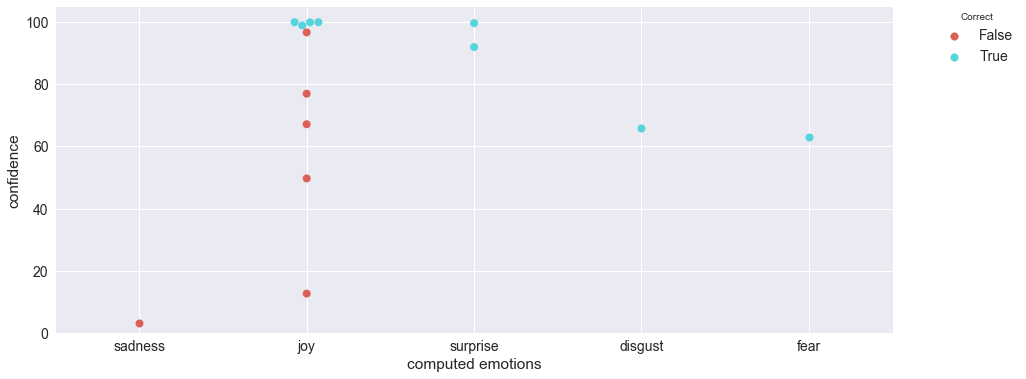

In [149]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))
# generate the swarmplot, colorize depending on whether the emotions were correctly inferred
_ = sns.swarmplot(x='computed', y='confidence', hue='correct', palette='hls', size=8, data=compare_df)
_.grid(True)
_.set_ylim(0, 105)
_.set_xlabel('computed emotions')
__ = _.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Correct')

In [127]:
# count nr of correctly inferred emotions
correct = compare_df.loc[compare_df.correct == True].shape[0]
incorrect = compare_df.shape[0] - correct
print('There are {} correct and {} incorrect emotions among all the APIs'.format(correct, incorrect))

There are 8 correct and 6 incorrect emotions among all the APIs


It's also interesting to see the result of each separate API.

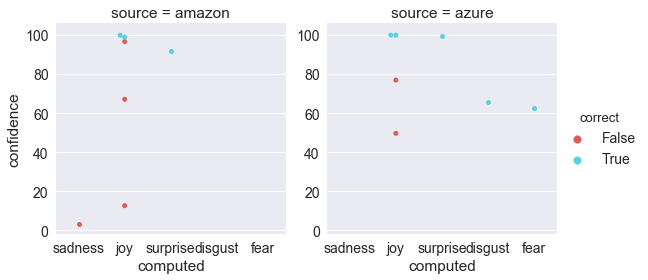

In [150]:
g = sns.factorplot(x='computed', y='confidence', hue='correct', palette='hls', kind='swarm', col='source', data=compare_df)

A table numerically summarizes the efficency of each API in detecting the different emotions. `-1` indicates that no emotion of that kind was found in the dataset, `0` indicates that there were pictures labeled with such emotion but the API was not able to identify the correct emotion in any of them.

In [192]:
# initialize the dataframe
table = pd.DataFrame(columns=label_df.emotion.unique(), index=compare_df.source.unique())

# get all the apis
apis = compare_df.source.unique()
for api in apis:
    # find the total nr of labeled emotions
    total = compare_df.loc[compare_df.source == api].real.value_counts()
    # find the total nr of correctly detected
    correct = compare_df.loc[(compare_df.source == api) & (compare_df.correct)].real.value_counts()
    # calculate the correct percentages
    table.loc[api] = np.round((correct/total)*100, 1)
    table.loc[api] = table.loc[api, list(total.index)].where(u.loc[api, list(total.index)] > 0, 0)
# NaNs are values for which no image was found with that emotion
table = table.fillna(-1.0)

table

,neutral,anger,sadness,joy,surprise,disgust,fear
amazon,-1.0,-1.0,-1.0,100.0,100.0,0.0,0.0
azure,-1.0,-1.0,-1.0,100.0,100.0,33.3,100.0


## Estimate the most difficult emotions to predict
According to the previous results it's reasonable to think that some emotions are more difficult to identify then others. Moreover some emotions are usually detected as others.

This section aims to understand how each real emotion is detected by the various APIs.

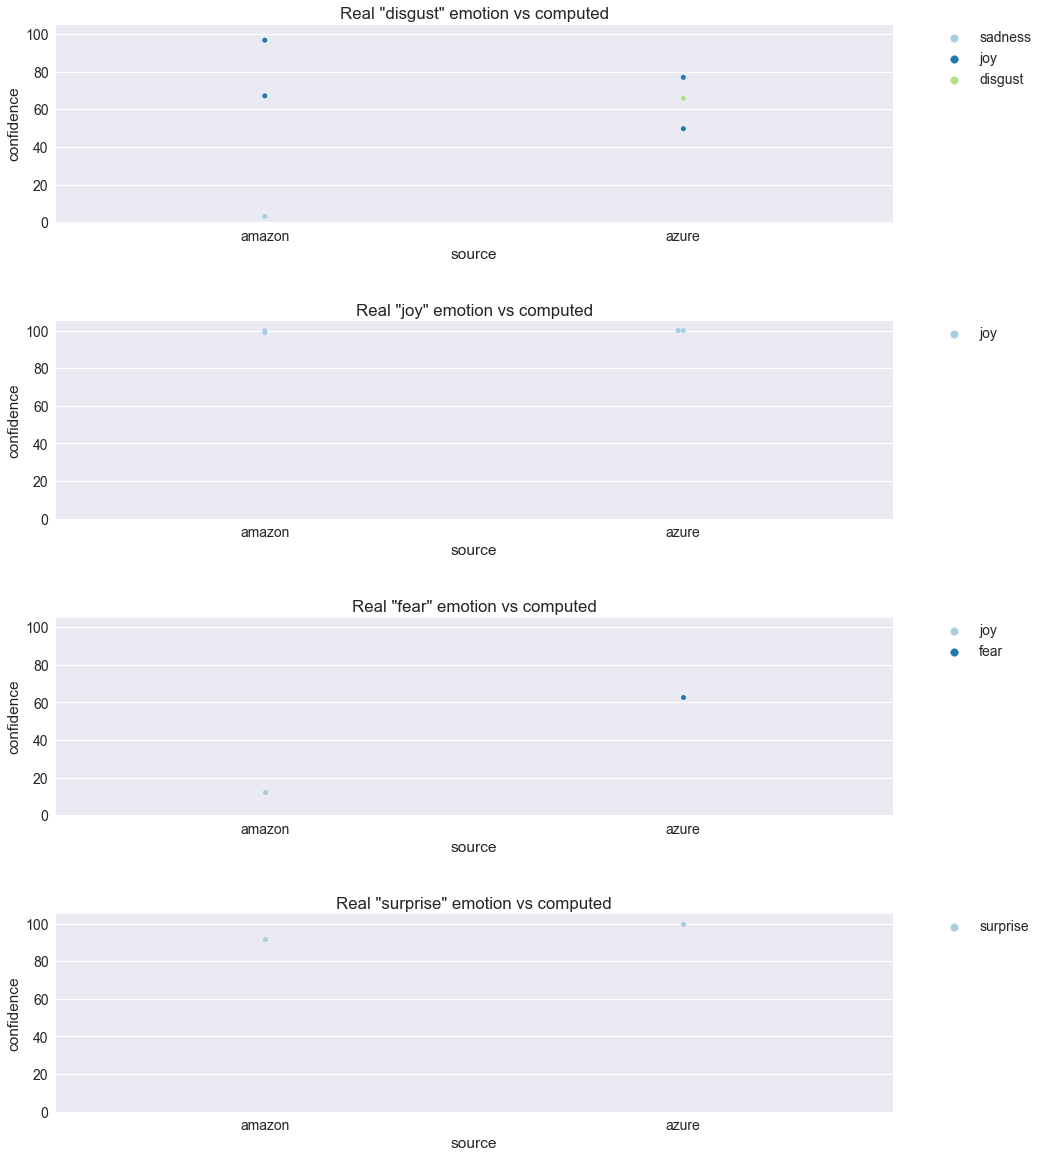

In [198]:
# count the nr of real emotions
emotions_real = compare_df.real.unique()
emotions_nr = emotions_real.shape[0]
# for each emotion, build the chart
fix, axes = plt.subplots(emotions_nr, 1, figsize=(15, 20))
# cycle and create all plots
for i in range(emotions_nr):
    _ = sns.swarmplot(x='source', y='confidence', hue='computed', data=compare_df.loc[compare_df.real == emotions_real[i]], ax=axes[i])
    _.set_title('Real "{}" emotion vs computed'.format(emotions_real[i]))
    _.set_ylim(0, 105)
    __ = _.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.subplots_adjust(wspace=.5, hspace=.5)

# 4. Analyze the evolution of emotions during a timeframe
In the context of this analisys only a single API was chosen and a short video was submitted for analysis.

In [4]:
api = 'amazon'
# get chosen api data
api_data = df.loc[df.source == api].sort_values('img_name')

In [5]:
api_data.iloc[0:3]

,img_name,source,anger,disgust,fear,joy,neutral,sadness,surprise
id,,,,,,,,,
S050_006_00000023_amazon,S050_006_00000023,amazon,0.000000,0.0,0.0,99.953857,0.0,0.0,0.000000
S060_002_00000026_amazon,S060_002_00000026,amazon,0.000000,0.0,0.0,98.946846,0.0,0.0,0.000000
S077_001_00000028_amazon,S077_001_00000028,amazon,2.991277,0.0,0.0,0.000000,0.0,0.0,91.978363


In [6]:
import logging
import multiprocessing
from multiprocessing import Process, Lock


lock = Lock()

def create_logger():
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
 
    fh = logging.FileHandler("process.log")
 
    fmt = '%(asctime)s - %(levelname)s - %(message)s'
    formatter = logging.Formatter(fmt)
    fh.setFormatter(formatter)
 
    logger.addHandler(fh)
    return logger
 
def printer(item):
    """
    Prints out the item that was passed in
    """
    lock.acquire()
    try:
        print(item)
    finally:
        lock.release()
if __name__ == '__main__':
    items = ['tango', 'foxtrot', 10]
    logger = create_logger()
    for item in items:
        p = Process(target=printer, args=(item,))
        p.start()

In [9]:
from multiprocessing import Process, current_process

def doubler(number):
    result = number * 2
    proc_name = current_process().name
    print('{0} doubled to {1} by: {2}'.format(number, result, proc_name))
    
if __name__ == '__main__':
    print('wui')
    numbers = [5, 10, 15, 20, 25]
    procs = []
    proc = Process(target=doubler, args=(5,))
 
    for index, number in enumerate(numbers):
        proc = Process(target=doubler, args=(number,))
        procs.append(proc)
        proc.start()
 
    proc = Process(target=doubler, name='Test', args=(2,))
    proc.start()
    procs.append(proc)
 
    for proc in procs:
        proc.join()

wui


In [ ]:
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import multiprocessing
import logging
# from itertools import repeat

fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[:-1, 1])
ax3 = plt.subplot(gs[-1, 1])

img = mpimg.imread('../img/S050_006_00000023.png')

img = ax1.imshow(img)
chart = ax2.plot(api_data.img_name, api_data.iloc[:, 2:])
line, = ax2.plot([0, 0], [0, 100], '--', linewidth=1, color='grey', zorder=2)
bar  = ax3.bar(api_data.columns[2:], api_data.iloc[0, 2:])

ax2.legend(api_data.iloc[:, 2:].columns, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)

def do_calculation(i):
    print('dentro')
#     ax1.imshow('../img/' + img)
#     line.set_xdata([i, i])
#     for i, b in enumerate(bar):
#         b.set_height(api_data.iloc[3, 2+i])
#     print('done')
#     plt.savefig('./video/' + str(i) + '.jpg')
    return i

def start_process():
    print('Starting', multiprocessing.current_process().name)

if __name__ == '__main__':
    multiprocessing.log_to_stderr(logging.DEBUG)
    print('here')
    frames = api_data.img_name + '.png'
    print(list(frames))
#     print(frames.img_name)
    pool_size = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(
        processes=pool_size,
        initializer=start_process
    )
    pool_outputs = pool.map(do_calculation, list(np.arange(frames.shape[0])))
    pool.close()  # no more tasks
    pool.join()  # wrap up current tasks
#     with multiprocessing.Pool(processes = pool_size) as pool:
#         print(frames.shape[0], list(frames))
#         pool.starmap(do_calculation, zip(np.arange(frames.shape[0]), list(frames)))


here
['S050_006_00000023.png', 'S060_002_00000026.png', 'S077_001_00000028.png', 'S087_004_00000012.png', 'S138_008_00000009.png', 'S151_002_00000029.png', 'S999_003_00000055.png']


# RANDOM TESTING

In [ ]:
# function to normalize row in order to make each value a percentage of the row total
def normalize(x):
    return x/x.sum()

# normalize each row so that it sums up to 1
a = rand_df.iloc[:, 2:].apply(normalize, axis=1)

#compare each of the random image above in all the APIs
fig, ax = plt.subplots(nr_rand_img, 2, figsize=(17, 20))

fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[:-1, 1])
ax3 = plt.subplot(gs[-1, 1])

# create the chart for each image
for i in range(nr_rand_img):
    current_img = rand_img[i]
    current_img_df = a.loc[rand_df.img_name == current_img]
    
    # read image from disk
    img = mpimg.imread('../scripts/apis/img/{}.png'.format(current_img))
    img = ax[i, 0].imshow(img, cmap='gray')
    ax[i, 0].axis('off')
    
    # initialize variable that will be needed to build the stacked barplot
    sum = [0]*current_img_df.shape[0]
    b = []
    # for each emotion, create the bar which will then be stacked
    for j, e in enumerate(current_img_df.columns):
        emotion = ax[i, 1].bar(current_img_df.index, current_img_df.iloc[:, j], 0.85, bottom=sum)
        b.append(emotion)
        sum += current_img_df.iloc[:, j]
    # show labeled emotion in chart title
    true_emotion = emotion_conversion[label_df.loc[current_img].emotion]
    ax[i, 1].set_title('Image: {} | True emotion: {}'.format(current_img, true_emotion))
    # add legend
    ax[i, 1].legend(b, current_img_df.columns, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)